MM detection은 code가 아닌 config 기반이기 때문에 내부 프레임워크를 정확히 이해해야 할 필요가 있음.

MS COCO가 아닌 KITTY 데이터를 MM detection이 필요로 하는 MS-COCO 스타일의 format으로 변환하는 것이 중요함.
 
 - 여러 개의 이미지에 대해 하나의 annotation 파일 (모든 이미지들에 대한 annotation 정보들을 list 객체로 가짐)
 - 1개 이미지는 bounding box, labels annotation 정보들을 개별 dictionary로 가짐

 ![image](https://user-images.githubusercontent.com/44194558/141766778-a0552e88-6cd7-4e31-b932-78bd5b82dc01.png)

참고 : https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb

<br/>

**middle format**

 ![image](https://user-images.githubusercontent.com/44194558/141764574-506a5d9c-63af-4808-a250-fcbfa1f90367.png)

In [1]:
import torch
print(torch.__version__)

1.10.0+cu111


In [ ]:
# Installation 참고 : https://mmcv.readthedocs.io/en/latest/get_started/installation.html
# https://github.com/open-mmlab/mmdetection/blob/master/docs/get_started.md
# The latest mmcv-full with CUDA 11.1 & PyTorch 1.10.0
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

In [1]:
# 실행하기 전에 '런타임 다시 시작'으로 kenel을 restart
from mmdet.apis import init_detector, inference_detector
import mmcv

In [2]:
!wget https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
!unzip kitti_tiny.zip > /dev/null

--2021-11-15 10:26:42--  https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.5
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918271 (6.6M) [application/zip]
Saving to: ‘kitti_tiny.zip’

kitti_tiny.zip      100%[===================>]   6.60M  8.45MB/s    in 0.8s    

2021-11-15 10:26:43 (8.45 MB/s) - ‘kitti_tiny.zip’ saved [6918271/6918271]



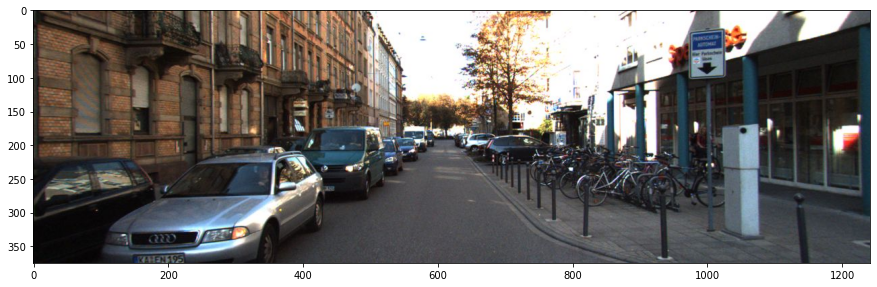

In [3]:
import matplotlib.pyplot as plt
import cv2

img = cv2.cvtColor(cv2.imread('/content/kitti_tiny/training/image_2/000068.jpeg'), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 10))
plt.imshow(img)

### KITTY 데이터 format 확인

- training 폴더의 image_2가 이미지 파일들이 저장된 폴더, label_2가 image_2 폴더의 각 이미지들에 대한 annotation 정보 

- train.txt는 annotation 파일들의 리스트들을 가지는 파일

![image](https://user-images.githubusercontent.com/44194558/141765774-ea2034e1-dfaa-4bb3-983a-a59f62bf1409.png)

<br/>


![image](https://user-images.githubusercontent.com/44194558/141766428-84ba1656-ed6f-4d29-a552-633edf7aba2e.png)

In [4]:
!cat /content/kitti_tiny/training/label_2/000068.txt

Car 0.25 0 1.94 69.26 200.28 435.08 374.00 1.46 1.62 4.04 -3.00 1.79 6.98 1.55
Car 0.80 1 2.26 0.00 209.20 198.59 374.00 1.46 1.58 3.72 -5.44 1.85 6.22 1.56
Cyclist 0.97 0 2.34 1210.28 199.77 1241.00 374.00 1.55 0.57 1.73 4.04 1.69 3.57 -3.14
Car 0.00 2 1.68 478.18 187.68 549.54 249.43 1.57 1.60 3.99 -2.73 2.03 20.96 1.55
Car 0.00 1 1.66 530.03 187.79 573.10 226.09 1.52 1.54 3.68 -2.53 2.20 31.50 1.58
Van 0.00 1 1.63 547.61 171.12 584.05 212.41 2.47 1.98 5.81 -2.79 2.41 46.44 1.57
Car 0.00 1 -0.16 667.74 182.35 790.82 230.38 1.62 1.65 4.14 4.19 1.99 25.95 0.00
Car 0.00 2 -0.11 657.37 184.48 763.34 221.64 1.55 1.66 4.47 4.35 2.10 32.00 0.02
Car 0.00 1 -0.01 637.45 180.34 714.44 212.34 1.69 1.76 4.12 3.59 2.12 39.79 0.08
Van 0.00 1 1.61 572.52 175.02 596.26 199.95 2.13 1.91 6.40 -2.28 2.36 65.43 1.57
Van 0.00 1 1.77 380.78 167.69 523.29 288.56 1.95 1.75 4.63 -2.89 1.90 14.05 1.57
Cyclist 0.00 1 1.09 958.95 167.55 1036.88 254.43 1.68 0.53 1.96 7.95 1.59 14.95 1.57


In [5]:
CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
cat2label = {k:i for i, k in enumerate(CLASSES)}
print(cat2label)
cat2label['Car']

{'Car': 0, 'Truck': 1, 'Pedestrian': 2, 'Cyclist': 3}


0

In [6]:
image_list = mmcv.list_from_file('/content/kitti_tiny/train.txt')

In [7]:
lines = mmcv.list_from_file('/content/kitti_tiny/training/label_2/000064.txt')
content = [line.strip().split(' ') for line in lines]

bbox_names = [x[0] for x in content]
bboxes = [ [float(info) for info in x[4:8]] for x in content]

print(bboxes)

[[657.65, 179.93, 709.86, 219.92], [731.51, 180.39, 882.28, 275.8], [715.18, 175.63, 762.77, 203.9], [816.58, 59.74, 1112.51, 266.07], [626.78, 174.27, 647.77, 192.18], [546.19, 168.97, 554.01, 177.09]]


### KITTY 데이터셋을 middle format으로 변환하여 로드

**middle format**

 ![image](https://user-images.githubusercontent.com/44194558/141764574-506a5d9c-63af-4808-a250-fcbfa1f90367.png)

In [14]:
import copy
import os.path as osp
import cv2

import mmcv
import numpy as np

In [5]:
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset
# https://github.com/open-mmlab/mmdetection/blob/6cf9aa1866b745fce8f1da6717fdb833d7c66fab/mmdet/datasets/custom.py#L18

CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
cat2label = {k:i for i, k in enumerate(CLASSES)}

@DATASETS.register_module(force=True)  # Dataset 객체를 config에 등록
class KittyTinyDataset(CustomDataset):  # CustomDataset 상속
    CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
    
    # load_annotations()를 재정의 -> 원본 소스를 middle format으로 변환
    # self.data_root: /content/kitti_tiny/ self.ann_file: /content/kitti_tiny/train.txt self.img_prefix: /content/kitti_tiny/training/image_2
    # ann_file은 파일 하나만 지정, img_prefix는 여러 개의 이미지들을 포함할 수 있는 디렉토리 형태로
    def load_annotations(self, ann_file):
        print('##### self.data_root:', self.data_root, 'self.ann_file:', self.ann_file, 'self.img_prefix:', self.img_prefix)
        print('#### ann_file:', ann_file)

        cat2label = {k:i for i, k in enumerate(self.CLASSES)}
        image_list = mmcv.list_from_file(self.ann_file)
        
        # 모든 이미지 파일의 middle format 데이터를 담을 list
        data_infos = []
        
        # train.txt에 있는 이미지 파일 id를 하나씩 처리
        for image_id in image_list:
            filename = '{0:}/{1:}.jpeg'.format(self.img_prefix, image_id)

            image = cv2.imread(filename)
            height, width = image.shape[:2]
            
            # 개별 이미지의 annotation 정보를 가지는 dictionary (개별 이미지의 annotation에 대한 middle format)
            # data_infos에 다수의 data_info
            # data_info의 'ann' key값으로 개별 이미지의 annotation 정보를 저장
            data_info = {'filename' : str(image_id) + '.jpeg',
                         'width' : width, 
                         'height' : height}
            
            # 개별 이미지에 대응되는 annotation 파일 label_2/{image_id}.txt 불러오기
            label_prefix = self.img_prefix.replace('image_2', 'label_2')
            lines = mmcv.list_from_file(osp.join(label_prefix, str(image_id)+'.txt'))

            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]  # 클래스 객체 정보
            bboxes = [[float(info) for info in x[4:8]] for x in content]  # bounding box 좌표 정보

            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
            
            # 하나의 이미지 파일에서 검출된 객체 클래스와 대응되는 bounding box 좌표 처리
            for bbox_name, bbox in zip(bbox_names, bboxes):
                # bbox_name이 클래스명에 해당되면 
                if bbox_name in cat2label:
                    gt_bboxes.append(bbox)
                    gt_labels.append(cat2label[bbox_name])
                
                # bbox_name이 클래스명에 해당되지 않으면
                else:
                    gt_bboxes_ignore.append(bbox)
                    gt_labels_ignore.append(-1)
            
            # 개별 이미지의 annotation 정보를 가지는 dictionary (위의 middle format 참고)
            data_anno = {'bboxes' : np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                         'labels' : np.array(gt_labels, dtype=np.long),
                         'bboxes_ignore' : np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
                         'labels_ignore' : np.array(gt_labels_ignore, dtype=np.long)}
            
            # data_anno 정보를 data_info에 'ann' key값으로 저장
            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos       

In [6]:
# Config 설정, Pretrained 모델 다운로드
config_file = '/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

In [ ]:
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

![image](https://user-images.githubusercontent.com/44194558/141777389-95c4a79d-1e2f-4cc3-b97c-348a238f8469.png)

<br/>

![image](https://user-images.githubusercontent.com/44194558/141778072-6633daa5-e45d-4508-b65e-f5c9ef54cb2e.png)

<br/>

![image](https://user-images.githubusercontent.com/44194558/141777541-910aa212-e7f8-4dcb-a862-d4f1274a9538.png)

<br/>

![image](https://user-images.githubusercontent.com/44194558/141777667-c2308f56-9098-42e0-aa0b-726d69884710.png)

In [10]:
print(cfg.keys())

dict_keys(['model', 'dataset_type', 'data_root', 'img_norm_cfg', 'train_pipeline', 'test_pipeline', 'data', 'evaluation', 'optimizer', 'optimizer_config', 'lr_config', 'runner', 'checkpoint_config', 'log_config', 'custom_hooks', 'dist_params', 'log_level', 'load_from', 'resume_from', 'workflow'])


In [11]:
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정. 
cfg.dataset_type = 'KittyTinyDataset'
cfg.data_root = '/content/kitti_tiny/'

# train에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정. 
cfg.data.train.type = 'KittyTinyDataset'
cfg.data.train.data_root = '/content/kitti_tiny/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image_2'

# val에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정.
cfg.data.val.type = 'KittyTinyDataset'
cfg.data.val.data_root = '/content/kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

# test에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정.
cfg.data.test.type = 'KittyTinyDataset'
cfg.data.test.data_root = '/content/kitti_tiny/'
cfg.data.test.ann_file = 'val.txt'
cfg.data.test.img_prefix = 'training/image_2'

# class 개수 수정. 
cfg.model.roi_head.bbox_head.num_classes = 4

# pretrained 모델
cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정. 
cfg.work_dir = './tutorial_exps'

# 학습율 변경 환경 파라미터 설정. 
cfg.optimizer.lr = 0.02 / 8

cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# config 수행 시마다 policy값이 없어지는 bug로 인하여 설정. 
cfg.lr_config.policy = 'step'

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

In [12]:
cfg.data.train.pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='LoadAnnotations', with_bbox=True),
            dict(type='Resize', img_scale=(1500, 900), keep_ratio=True),
            dict(type='RandomFlip', flip_ratio=0.5),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size_divisor=32),
            dict(type='DefaultFormatBundle'),
            dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
        ]

cfg.data.val.pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(1500, 900),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='Pad', size_divisor=32),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='Resize', img_scale=(1500, 900), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1500, 900),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]
# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

In [ ]:
print(f'Config:\n{cfg.pretty_text}')

### config에서 설정한 데이터셋, 모델, pipeline에 따라 학습 진행

In [15]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# train용 Dataset 생성. 
datasets = [build_dataset(cfg.data.train)]

##### self.data_root: /content/kitti_tiny/ self.ann_file: /content/kitti_tiny/train.txt self.img_prefix: /content/kitti_tiny/training/image_2
#### ann_file: /content/kitti_tiny/train.txt


/usr/local/lib/python3.7/dist-packages/mmdet-2.18.0-py3.7.egg/mmdet/datasets/custom.py:157: UserWarning: CustomDataset does not support filtering empty gt images.
  'CustomDataset does not support filtering empty gt images.')


In [16]:
datasets

[
 KittyTinyDataset Train dataset with number of images 50, and instance counts: 
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+
 | category | count | category  | count | category       | count | category    | count | category      | count |
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+
 | 0 [Car]  | 147   | 1 [Truck] | 7     | 2 [Pedestrian] | 23    | 3 [Cyclist] | 7     | -1 background | 0     |
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+]

In [17]:
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES

In [18]:
%cd mmdetection 

# Train
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/content/mmdetection


2021-11-15 12:01:33,578 - mmdet - INFO - load checkpoint from local path: checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth


##### self.data_root: /content/kitti_tiny/ self.ann_file: /content/kitti_tiny/val.txt self.img_prefix: /content/kitti_tiny/training/image_2
#### ann_file: /content/kitti_tiny/val.txt


2021-11-15 12:01:33,707 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([5, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([5]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([16, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([16]).
2021-11-15 12:01:33,712 - mmdet - INFO - Start running, host: root@8ff68c539b21, work_dir: /content/mmdetection/tutorial_exps
2021-11-15 12:01:33,716 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH  

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 13.1 task/s, elapsed: 2s, ETA:     0s
---------------iou_thr: 0.5---------------


2021-11-15 12:03:31,149 - mmdet - INFO - 
+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 62  | 147  | 0.968  | 0.841 |
| Truck      | 3   | 24   | 1.000  | 0.500 |
| Pedestrian | 13  | 52   | 0.846  | 0.720 |
| Cyclist    | 7   | 48   | 0.429  | 0.056 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.529 |
+------------+-----+------+--------+-------+
2021-11-15 12:03:31,152 - mmdet - INFO - Epoch(val) [12][25]	AP50: 0.5290, mAP: 0.5295


### Inference

/usr/local/lib/python3.7/dist-packages/mmdet-2.18.0-py3.7.egg/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


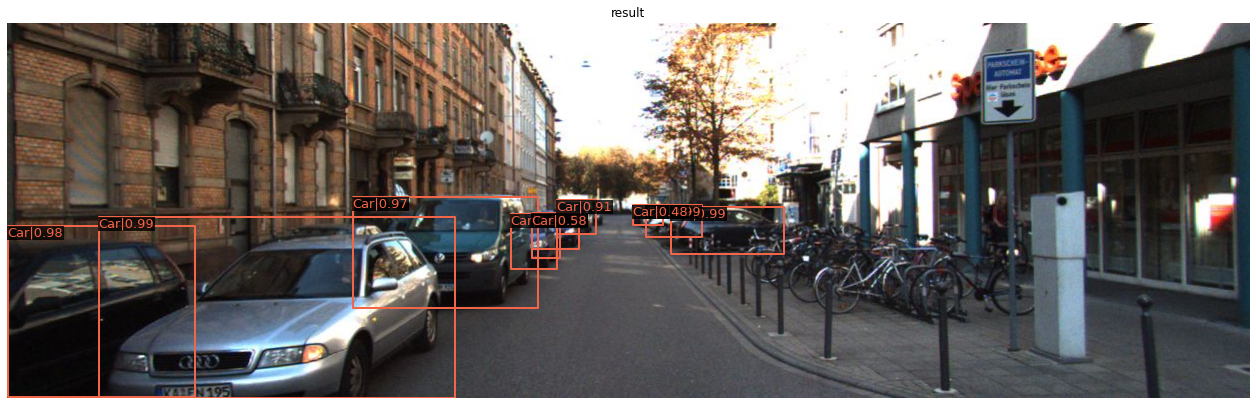

In [19]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# BGR Image 사용 
img = cv2.imread('/content/kitti_tiny/training/image_2/000068.jpeg')

model.cfg = cfg

result = inference_detector(model, img)
show_result_pyplot(model, img, result)

### Video Detection

In [ ]:
%cd /content
!mkdir /content/data
!wget -O /content/data/the_rock_chase.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/the_rock_chase.mp4?raw=true

In [21]:
CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
labels_to_names_seq = {i:k for i, k in enumerate(CLASSES)}

CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
cat2label = {k:i for i, k in enumerate(CLASSES)}

In [22]:
CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
cat2label = {k:i for i, k in enumerate(CLASSES)}

def get_detected_img(model, img_array,  score_threshold=0.3, is_print=True):
  
    draw_img = img_array.copy()  # 입력 image_array 복사
    bbox_color=(0, 255, 0)
    text_color=(0, 0, 255)
  
    # Inference 수행
    results = inference_detector(model, img_array)

    for result_ind, result in enumerate(results):
        # 해당 객체가 이미지에서 검출되지 않았다면
        if len(result) == 0:
            continue
      
        # array에서 confidence score가 지정된 ths보다 높은 요소만 추출
        result_filtered = result[np.where(result[:, 4] > score_threshold)]

        for i in range(len(result_filtered)):
            left = int(result_filtered[i, 0])  # xmin
            top = int(result_filtered[i, 1])  # ymin
            right = int(result_filtered[i, 2])  # xmax
            bottom = int(result_filtered[i, 3])  # ymax

            caption = "{}: {:.4f}".format(labels_to_names_seq[result_ind], result_filtered[i, 4])
            cv2.rectangle(draw_img, (left, top), (right, bottom), color=bbox_color, thickness=2)
            cv2.putText(draw_img, caption, (int(left), int(top - 7)), cv2.FONT_HERSHEY_SIMPLEX, 0.37, text_color, 1)

            if is_print:
                print(caption)

    return draw_img

In [24]:
import time

def do_detected_video(model, input_path, output_path, score_threshold, do_print=True):
    
    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')
    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size) 

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)

    btime = time.time()
    while True:
        # 동영상 파일을 frame 단위로 불러오기
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다')
            break
        stime = time.time()
        # 동영상의 이미지 frame에 대해 object detection 수행
        img_frame = get_detected_img(model, img_frame, score_threshold=score_threshold, is_print=False)
        if do_print:
            print('frame별 detection 수행 시간:', round(time.time() - stime, 4))
        # detection 결과 반영     
        vid_writer.write(img_frame)

    vid_writer.release()
    cap.release()

    print('최종 detection 완료 수행 시간:', round(time.time() - btime, 4))    

In [ ]:
do_detected_video(model, '/content/data/the_rock_chase.mp4', '/content/data/the_rock_chase_out1.mp4', score_threshold=0.4, do_print=True)